## Opens a basemap in image location and prints list of coordinates selected by user

## Imports

In [1]:
import os
import sys
from pathlib import Path
import datetime

from ipywidgets import Label
from ipyleaflet  import Map, GeoData, basemaps, LayersControl, ImageOverlay, Marker
from localtileserver import get_leaflet_tile_layer, TileClient

%matplotlib inline

In [2]:
sys.path.append(r"../LUCinSA_helpers")
from file_info import *
from plot import *

In [3]:
'''
PARAMETERS: modify in Notebook_settings notebook, then run that notebook and this cell to update here
DO not modify this cell
'''

%store -r basic_config
print("Basic Parameters: \n PrintDate = {} \n brdf_dir = {} \n grid_cell = {} \n index_dir = {} \n out_dir = {}"
      .format(basic_config['today'], basic_config['brdf_dir'],basic_config['grid_cell'],basic_config['index_dir'],basic_config['out_dir']))

%store -r single_plot_params
print("Plotting Parameters: \n plot_yr = {} \n plot_day = {} \n viewband = {} \n image_type = {}"
      .format(single_plot_params['plot_yr'],single_plot_params['plot_day'],single_plot_params['viewband'],single_plot_params['image_type']))

%store -r interactive_plot_params
print( "Shapefile = {} \n If point, file is {} \n If poly, file is {} \n input crs = {}"
     .format (interactive_plot_params['shpfile'], interactive_plot_params['ptfile'],interactive_plot_params['polyfile'],interactive_plot_params['inputCRS']))

Basic Parameters: 
 PrintDate = 2023-08-20 
 brdf_dir = /home/sandbox-cel/paraguay_lc/stac/grid/003773/brdf 
 grid_cell = 3773 
 index_dir = /home/downspout-cel/paraguay_lc/stac/grids/003773/brdf_ts/ms/ndmi 
 out_dir = /home/klwalker/data/tmp
Plotting Parameters: 
 plot_yr = 2021 
 plot_day = 100 
 viewband = nir 
 image_type = AllRaw
Shapefile = poly 
 If point, file is /home/klwalker/data/tmp/SelectedCoords.csv 
 If poly, file is /home/downspout-cel/paraguay_lc/vector/TestPolys/YerbaMatte_GEpolysEE.shp 
 input crs = epsg:8858


In [4]:
## Get a sample image of type image_type, closest to the date specified with plot_day and plot_yr parameters
if single_plot_params['image_type'] == 'Smooth':
    samp_img = get_closest_image(basic_config['index_dir'],single_plot_params['image_type'],basic_config['data_source'],single_plot_params['plot_yr'],single_plot_params['plot_day'])
else:
    samp_img = get_closest_image(basic_config['brdf_dir'],single_plot_params['image_type'],basic_config['data_source'],single_plot_params['plot_yr'],single_plot_params['plot_day'])

print(samp_img)

/home/sandbox-cel/paraguay_lc/stac/grid/003773/brdf/L3A_LC08_brdf22507802T1_20210410_20230210_C01.nc with file size 28291824
/home/sandbox-cel/paraguay_lc/stac/grid/003773/brdf/L3A_LC08_brdf22507802T1_20210410_20230210_C01.nc


## image with color correction, but not interactive

  0%|          | 0/289 [00:00<?, ?it/s]

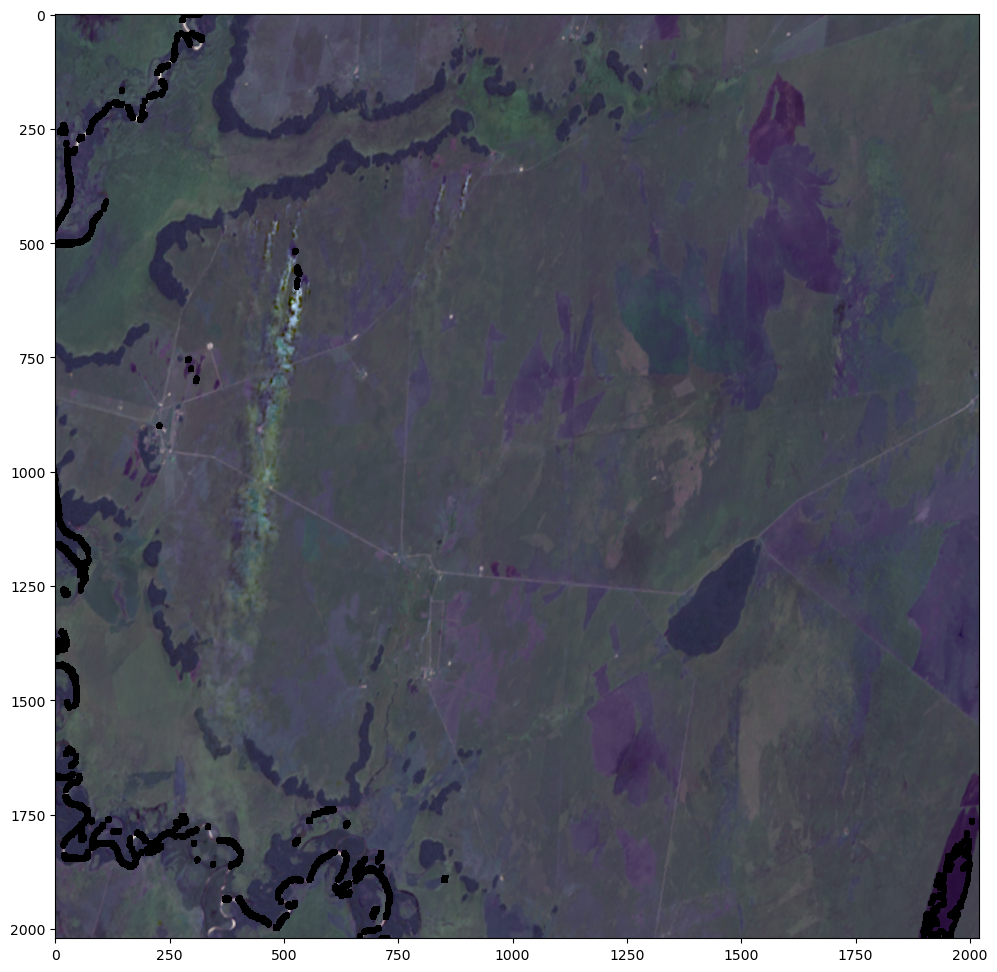

In [5]:
img = samp_img
img_tif = nc_to_tif(img, out_dir=basic_config['out_dir'])
rgb = get_rbg_img(img_tif,single_plot_params['gamma'])
fig = plt.figure(figsize=(18,12))
plt.imshow(rgb)

## Interactive version

In [8]:
img = samp_img
img_tif = nc_to_tif(img, out_dir=basic_config['out_dir'])
#m,t = show_interactive_img(img, 5555, out_dir=basic_config['out_dir'])
tile_client = TileClient(img_tif,port=5555)
m = Map(center=tile_client.center(), zoom=12, basemap=basemaps.Esri.WorldImagery)
t = get_leaflet_tile_layer(tile_client, band=[1,2,3])
m.add_layer(t)
m

  0%|          | 0/289 [00:00<?, ?it/s]

Map(center=[-26.554119489811697, -56.705832735920794], controls=(ZoomControl(options=['position', 'zoom_in_tex…

[[-26.51872666850549, -56.75050162710251]]
[[-26.51872666850549, -56.75050162710251], [-26.554970691502458, -56.74878501333296]]
[[-26.51872666850549, -56.75050162710251], [-26.554970691502458, -56.74878501333296], [-26.550364035732542, -56.662611002102494]]
[[-26.51872666850549, -56.75050162710251], [-26.554970691502458, -56.74878501333296], [-26.550364035732542, -56.662611002102494], [-26.579966246619502, -56.65540122427048]]


In [ ]:
#add_shpfile_overlay(shp=interactive_plot_params['shpfile'],ptfile=interactive_plot_params['ptfile'],inputCRS=interactive_plot_params['inputCRS'],polyfile=interactive_plot_params['polyfile'])

In [9]:
def get_coords(**kwargs):
    if kwargs.get('type') == 'click':
        label = Label()
        label.value = str(kwargs.get('coordinates'))
        coords =eval(label.value) 
        selected_coords.append(coords)
        print(selected_coords)
        return selected_coords

selected_coords = []
m.on_interaction(get_coords)

## Get list of coordinates to use (first click on map above)
#### list is saved as 'out_dir/SelectedCoords.csv'

In [10]:
coords = convert_and_print_coord_list(selected_coords, img_crs=interactive_plot_params['inputCRS'], out_dir=basic_config['out_dir'])

3025195.249 -3345306.387
3024917.519 -3349705.223
3032812.236 -3349146.166
3033112.373 -3352738.439


## Get Values at Coordinates

In [11]:
get_values_at_coords(coords, interactive_plot_params['inputCRS'], img_tif, [1,2,3])

{1: [210.0, 209.0, 296.0, 189.0],
 2: [591.0, 543.0, 631.0, 365.0],
 3: [450.0, 374.0, 668.0, 211.0]}

## To save an html copy of this notebook with all outputs:

In [ ]:
### Run to print output as html
outName = str(basicConfig['country']+'1c_InteractiveMapSession'
!jupyter nbconvert --output-dir='./Outputs' --to html --no-input --output=$outName 1c_ExploreData_InteractiveMap.ipynb